In [1]:
## This Notebook will Utilize Best Subset Selection on the Hitters Dataset
## imports
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import statsmodels.api as sm
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
(Stepwise,
sklearn_selected,
sklearn_selection_path)
import matplotlib.pyplot as plt


In [2]:
## Load Hitters Data from ISLP package
hitters = load_data('Hitters')
np.isnan(hitters['Salary']).sum()

## Get Categorical Variables
#print(hitters.dtypes)
categorical_cols = hitters.select_dtypes(include=['category']).columns.tolist()
#print(categorical_cols)

## Drop 59 Null Rows
hitters = hitters.dropna()

## One Hot Encode Categorical Columns
one_hot_hitters = pd.get_dummies(hitters, drop_first=True)

In [5]:
display(one_hot_hitters)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,1,0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,1,0,1
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,325,9,3,700.0,1,0,1
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,313,381,20,875.0,0,0,0
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,37,113,7,385.0,0,1,0
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,1314,131,12,960.0,0,0,0


## Principal Components Regression
- PCR can be performed with the PCA() Function from the sklearn.decomposition module. 

- We apply PCA() to the Hitters data to predict Salary
    - We use Linear Regression() to fit the regression model

In [13]:
## When performing PCA, we must standardize the data first.

X = one_hot_hitters.drop(columns=['Salary'])
y = one_hot_hitters.Salary


## Scale the Variables
scaler = StandardScaler()

## Define PCA and Regression Method
linreg = skl.LinearRegression()
pca = PCA(n_components=2)

## Define Pipeline
pipe = Pipeline(
    [
        ('scaler', scaler),
        ('pca', pca),
        ('linreg', linreg)
    ]
)

pipe.fit(X, y)
pipe.named_steps['linreg'].coef_

array([106.36859204, -21.60350456])

In [14]:
## We now use CV to choose the number of components, by using skm.GridSearchCV

## Define number of folds
k = 5
kfold = skm.KFold(
    k,
    random_state=0,
    shuffle=True
)

param_grid = {'pca__n_components': range(1,20)}
grid = skm.GridSearchCV(
    pipe,
    param_grid,
    cv=kfold,
    scoring='neg_mean_squared_error'
)

grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

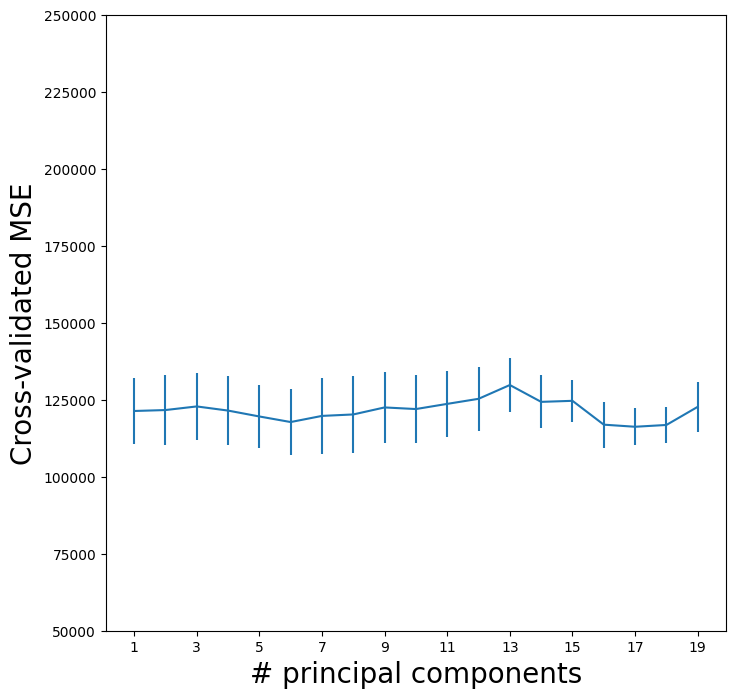

In [15]:
pcr_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,

-grid.cv_results_['mean_test_score'],
grid.cv_results_['std_test_score'] / np.sqrt(k))

ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000,250000]);

We see that the smallest cross-validation error occurs when 17 principal components are used. However, from the plot we also see that the cross-validation error is roughly the same when only one component is included in the model. this suggests that a model that uses just a small number of components might suffice

In [16]:
## Here we compute the MSE for just the null model

Xn = np.zeros((X.shape[0], 1))

cv_null = skm.cross_validate(
    linreg,
    Xn,
    y,cv=kfold,
    scoring='neg_mean_squared_error'
)

-cv_null['test_score'].mean()

204139.30692994667

In [17]:
## The explained_variance_ratio_ attribute of our PCA object provides the percentage of variance explained in the predictors and in the response using different numbers of components.

pipe.named_steps['pca'].explained_variance_ratio_

array([0.3831424 , 0.21841076])

This is the amount of information about the predicotrs that is caputred by using M principal components.
- Setting M=1 Only captures 38.31% of the variance
- M = 2 captures and <b>additional</b> 21.84% for a total of 60.15% of the variance

- By M = 6 it increases to 88.63%

## Partial Least Squares

- Is inplemented with the PLSRegression() Function

In [18]:
pls = PLSRegression(
    n_components=2,
    scale=True
    )

pls.fit(X, y)

PLSRegression()

In [19]:
## Want to use CV to choose the number of components

param_grid = {'n_components':range(1, 20)}
grid = skm.GridSearchCV(
    pls,
    param_grid,
    cv=kfold,
    scoring='neg_mean_squared_error'
    )

grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

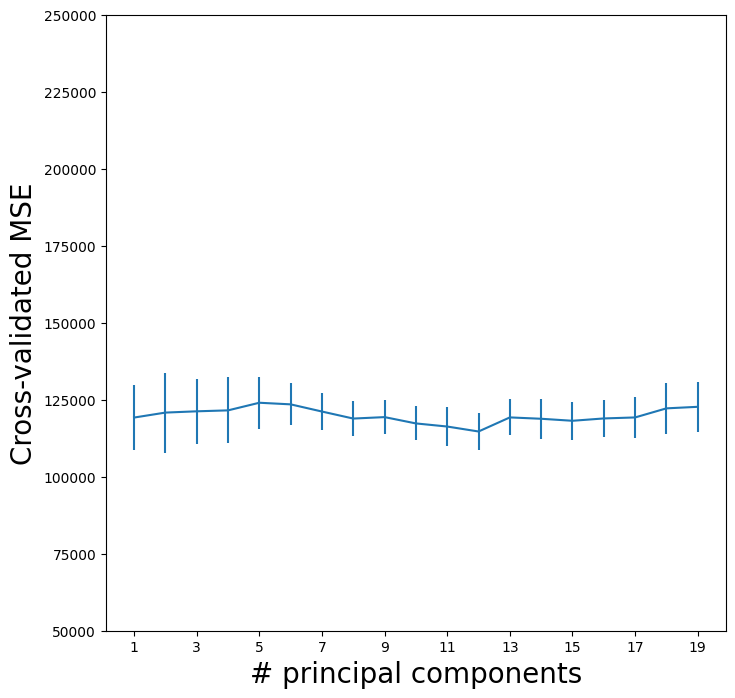

In [21]:
pls_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp,

-grid.cv_results_['mean_test_score'],
grid.cv_results_['std_test_score'] / np.sqrt(k))

ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000,250000]);

CV Error is minimized at 12 but we can see that this MSE is very similar to the MSE at a fewer number of components like 2 or 3